In [2]:
!pip install kagglehub split-folders

In [3]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from collections import Counter
import splitfolders

tf.random.set_seed(3)

In [4]:
dataset_path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

input_dir = os.path.join(dataset_path, "Driver Drowsiness Dataset (DDD)")
output_dir = '/content/splitted_Data'

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Copying files: 41793 files [04:22, 159.37 files/s]


In [5]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
val_dir = os.path.join(output_dir, "val")

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_batches = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=16, class_mode='binary', shuffle=True)

test_batches = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=16, class_mode='binary', shuffle=True)

val_batches = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=16, class_mode='binary', shuffle=True)

train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


In [7]:
print("Train:", train_class_indices, train_class_counts)
print("Test:", test_class_indices, test_class_counts)
print("Val:", val_class_indices, val_class_counts)

Train: {'Drowsy': 0, 'Non Drowsy': 1} Counter({np.int32(0): 17878, np.int32(1): 15556})
Test: {'Drowsy': 0, 'Non Drowsy': 1} Counter({np.int32(0): 1118, np.int32(1): 973})
Val: {'Drowsy': 0, 'Non Drowsy': 1} Counter({np.int32(0): 3352, np.int32(1): 2916})


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(data, class_names, num_images=5):
    images, labels = next(data)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        label_index = int(labels[i])
        plt.title(f"{list(class_names.keys())[label_index]} ({label_index})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

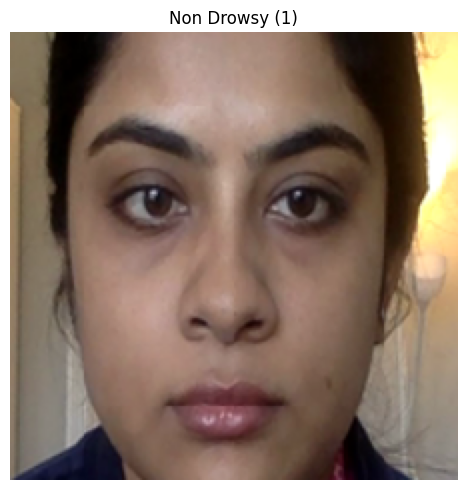

In [9]:
show_random_images(train_batches, train_class_indices, num_images=1)

In [10]:
image_size = (224, 224)
batch_size = 16

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

for layer in base_model.layers[:-25]:
    layer.trainable = False

In [11]:
from tensorflow.keras.layers import GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,095,041 (15.62 MB)

 Trainable params: 3,198,977 (12.20 MB)

 Non-trainable params: 896,064 (3.42 MB)

In [13]:
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 216s 95ms/step - accuracy: 0.9752 - loss: 0.0602 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 2/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 162s 77ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9997 - val_loss: 4.3980e-04
Epoch 3/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 154s 74ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.9998 - val_loss: 3.1400e-04
Epoch 4/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 154s 74ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9997 - val_loss: 5.1840e-04
Epoch 5/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 173s 83ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 6/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9998 - val_loss: 4.3289e-04
Epoch 7/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 9.3729e-05
Epoch 8/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 152s 73ms/step - a

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 132s 63ms/step - accuracy: 0.9999 - loss: 1.8467e-04
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9995 - loss: 0.0030
Training Accuracy: 99.99%
Test Accuracy: 99.95%
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
Confusion Matrix:
 [[1117    1]
 [   0  973]]


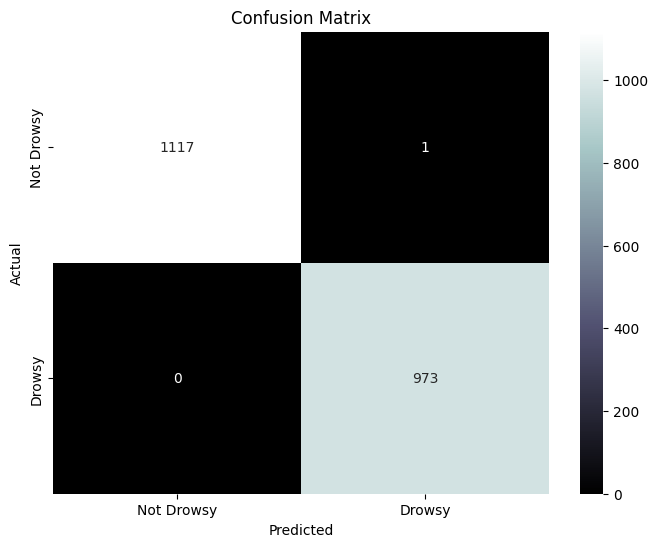

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

test_batches.shuffle = False

train_loss, train_acc = model.evaluate(train_batches)
test_loss, test_acc = model.evaluate(test_batches)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred_probs = model.predict(test_batches)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)
y_true = test_batches.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone',
            xticklabels=['Not Drowsy', 'Drowsy'],
            yticklabels=['Not Drowsy', 'Drowsy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
report = classification_report(y_true, y_pred, target_names=['Not Drowsy', 'Drowsy'])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

  Not Drowsy       1.00      1.00      1.00      1118
      Drowsy       1.00      1.00      1.00       973

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


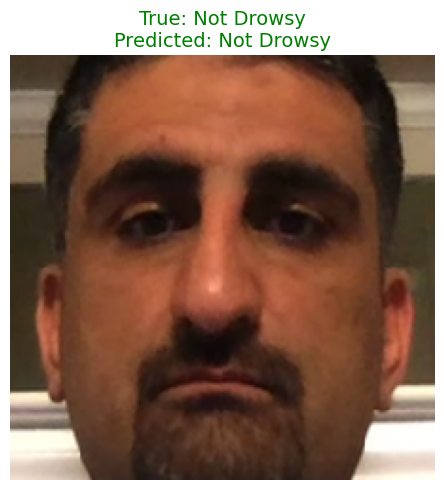

In [16]:
import random

test_images, test_labels = next(test_batches)
idx = random.randint(0, len(test_images) - 1)

sample_image = test_images[idx]
true_label = int(test_labels[idx])
pred_label = int((model.predict(np.expand_dims(sample_image, axis=0)) > 0.5).astype("int32")[0][0])

plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title(f"True: {'Drowsy' if true_label else 'Not Drowsy'}\nPredicted: {'Drowsy' if pred_label else 'Not Drowsy'}",
          fontsize=14, color='green' if pred_label == true_label else 'red')
plt.axis('off')
plt.tight_layout()
plt.show()